# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [ ]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime

from scipy.stats import chi2_contingency
from scipy.stats import chi2

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, stddev,col, concat, desc, isnan, explode, lit, count, when, sort_array, asc, avg, min, max, split, udf, isnull, countDistinct
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import Row
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
%matplotlib inline

In [ ]:
# Create a Spark Session
spark = SparkSession \
.builder \
.appName('Sparkify') \
.getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [ ]:
# Load data and store it into a Spark dataframe
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

In [ ]:
# Structure of the dataframe
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [ ]:
# Print first line
df = spark.read.json('mini_sparkify_event_data.json')
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [ ]:
# Describe user ID
df.count()

286500

In [ ]:
# Check userId null values
df.filter(isnull(df['userId'])).count()

0

In [ ]:
# Check sessionId null values
df.filter(isnull(df['sessionId'])).count()

0

In [ ]:
# Check userId missing values
df.filter(df['userId']=='').count()

8346

In [ ]:
# Check sessionId missing values
df.filter(df['sessionId']=='').count()

0

In [ ]:
# Remove userId with no values
df_clean = df.filter(df['userId']!='')

In [ ]:
df_clean.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [ ]:
# Sparksql
# Create a temporary view to perform SQL operations
df_clean.createOrReplaceTempView("Sparkify_clean")

In [ ]:
# Explore auth by user
spark.sql('''
        SELECT auth,COUNT(DISTINCT userId) AS distinct_users
        FROM Sparkify_clean
        GROUP BY auth
        ORDER BY distinct_users DESC
''').show()

+---------+--------------+
|     auth|distinct_users|
+---------+--------------+
|Logged In|           225|
|Cancelled|            52|
+---------+--------------+



In [ ]:
# Explore Gender
gender_count = spark.sql('''
        SELECT gender,COUNT(DISTINCT userId) AS distinct_users
        FROM Sparkify_clean
        GROUP BY gender
        ORDER BY distinct_users DESC
''').show()

+------+--------------+
|gender|distinct_users|
+------+--------------+
|     M|           121|
|     F|           104|
+------+--------------+



In [ ]:
# Explore Item in sessions
spark.sql('''
        SELECT COUNT(DISTINCT(itemInSession)) AS item_counts
        FROM Sparkify_clean
''').show()

+-----------+
|item_counts|
+-----------+
|       1311|
+-----------+



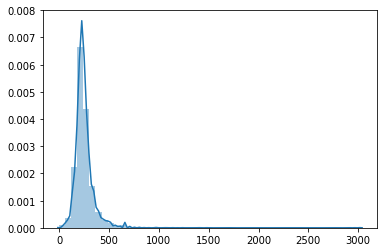

In [ ]:
# Explore length distribution
length = spark.sql('''
        SELECT length
        FROM Sparkify_clean
''').toPandas()

# Length Density viz
sns.distplot(length.dropna())

In [ ]:
# Explore account type
spark.sql('''
        SELECT level,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_clean
        GROUP BY level
        ORDER BY user_counts DESC
''').show()

+-----+-----------+
|level|user_counts|
+-----+-----------+
| free|        195|
| paid|        165|
+-----+-----------+



In [ ]:
# Explore page by user
spark.sql('''
        SELECT page,COUNT(userId) AS user_counts
        FROM Sparkify_clean
        GROUP BY page
        ORDER BY user_counts DESC
''').show()

+--------------------+-----------+
|                page|user_counts|
+--------------------+-----------+
|            NextSong|     228108|
|           Thumbs Up|      12551|
|                Home|      10082|
|     Add to Playlist|       6526|
|          Add Friend|       4277|
|         Roll Advert|       3933|
|              Logout|       3226|
|         Thumbs Down|       2546|
|           Downgrade|       2055|
|            Settings|       1514|
|                Help|       1454|
|             Upgrade|        499|
|               About|        495|
|       Save Settings|        310|
|               Error|        252|
|      Submit Upgrade|        159|
|    Submit Downgrade|         63|
|              Cancel|         52|
|Cancellation Conf...|         52|
+--------------------+-----------+



### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.


In [ ]:
# Add a new colum called time to see clearly the timestamp
get_datetime = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df_clean = df_clean.withColumn("datetime", get_datetime(df_clean.ts))

In [ ]:
#next, let's take a look at the userId 100001
df_clean.select(['datetime','userId','page','artist','song']).filter(df_clean['userId'] == 100001)\
.sort('datetime',ascending=False).show(20)

+-------------------+------+--------------------+--------------------+--------------------+
|           datetime|userId|                page|              artist|                song|
+-------------------+------+--------------------+--------------------+--------------------+
|2018-10-02 16:36:45|100001|Cancellation Conf...|                null|                null|
|2018-10-02 16:34:34|100001|              Cancel|                null|                null|
|2018-10-02 16:34:33|100001|         Roll Advert|                null|                null|
|2018-10-02 16:33:52|100001|            NextSong|            Harmonia|       Sehr kosmisch|
|2018-10-02 16:29:46|100001|                Home|                null|                null|
|2018-10-02 16:29:19|100001|              Logout|                null|                null|
|2018-10-02 16:29:18|100001|            NextSong|           Lady GaGa|           Alejandro|
|2018-10-02 16:24:34|100001|            NextSong|Michael BublÃÂ© ...|Quando_ Qu

In [ ]:
# Create a churn column which will contain 1 if the user cancelled, 0 otherwise
cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

df_clean = df_clean.withColumn("churn", cancellation_event('page'))
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df_clean = df_clean.withColumn("churn",Fsum("churn").over(windowval))

In [ ]:
#let's reuse userId=100001 to confirm that the column Churn is indeed == 1 when the page event is 'Cancellation confirmation'
df_clean.select(['datetime','userId','page','artist','song','churn']).filter(df_clean['userId'] == 100005)\
.sort('datetime',ascending=False).show(10)


+-------------------+------+--------------------+---------------+--------------------+-----+
|           datetime|userId|                page|         artist|                song|churn|
+-------------------+------+--------------------+---------------+--------------------+-----+
|2018-10-19 17:57:05|100005|Cancellation Conf...|           null|                null|    1|
|2018-10-19 17:56:50|100005|              Cancel|           null|                null|    1|
|2018-10-19 17:56:49|100005|            Settings|           null|                null|    1|
|2018-10-19 17:56:43|100005|                Help|           null|                null|    1|
|2018-10-19 17:56:40|100005|            NextSong|      Chris Rea|Driving Home For ...|    1|
|2018-10-19 17:52:10|100005|            NextSong|    Gipsy Kings|         Trista Pena|    1|
|2018-10-19 17:49:21|100005|            NextSong|  Flat Duo Jets|     My Life My Love|    1|
|2018-10-19 17:42:56|100005|            NextSong|Jimmy Eat World|     

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [ ]:
# Print again the dataframe schema
df_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- churn: long (nullable = true)



In [ ]:
print('number of distinct users in sparkify : {}'\
    .format(df_clean.select('userId').drop_duplicates().count()))

number of distinct users in sparkify : 225


In [ ]:
# Total amount of churned users
print('total amount of churned users : {}'.format(df_clean.select('userId')\
                                            .where(df_clean.churn == 1).drop_duplicates().count()))

total amount of churned users : 52


In [ ]:
print('percentage of churned users : {}%'\
      .format(round(100*(df_clean.select('userId').where(df_clean.churn == 1)\
                         .drop_duplicates().count())/df_clean.select('userId')\
                         .drop_duplicates().count())))

percentage of churned users : 23%


In [ ]:
# Get churn rates based on Gender
pd_gender = df_clean.select(['userId','Churn','gender']).\
drop_duplicates(["userId","churn",'gender']).groupby(["churn","gender"]).count().toPandas()
pd_gender

,churn,gender,count
0,0,F,84
1,1,M,32
2,1,F,20
3,0,M,89


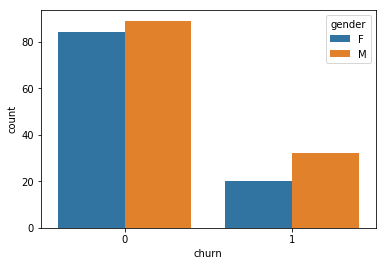

In [ ]:
# Gender churn viz
sns.barplot(x='churn',y='count',hue='gender',data=pd_gender)

In [ ]:
# contingency table
table = [[pd_gender.iat[1,2], pd_gender.iat[3,2],],[pd_gender.iat[2,2],pd_gender.iat[0,2]]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)

# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))

#If Statistic >= Critical Value: significant result, reject null hypothesis (H0), dependent.
#If Statistic < Critical Value: not significant result, fail to reject null hypothesis (H0), independent.

if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0), gender seems to be not significant in determining churn or not')


[[32, 89], [20, 84]]
dof=1
[[ 27.96444444  93.03555556]
 [ 24.03555556  79.96444444]]
probability=0.950, critical=3.841, stat=1.258
Independent (fail to reject H0)
significance=0.050, p=0.262
Independent (fail to reject H0), gender seems to be not significant in determining churn or not


In [ ]:
# Get churn rates based on Page
churned = users.filter(users.churn==1)
active = users.filter(users.churn==0)

n_churned = churned.count()
n_active  = active.count()

churned_df= churned.filter(churned.page!="NextSong").groupby(["page"]).count()
churned_df= churned_df.withColumn("Churned", churned_df["count"]/(n_churned)).sort("page")

active_df = active.filter(active.page!="NextSong").groupby(["page"]).count()
active_df = active_df.withColumn("Active", active_df["count"]/(n_active)).sort("page")

churned_active_df = churned_df.join(active_df, "page", "outer").drop("count")\
    .fillna(0).toPandas()

churned_active_df.head()

In [ ]:
# Page churn viz

churned_active_df.plot.bar("page");
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Page or Activity", fontsize=10)
plt.ylabel("Fraction", fontsize=10)
plt.title("Distribution of page visits by churned users vs active users", fontsize=13)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(loc='best', fontsize=9);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [ ]:
# Make gender to binary

Gender = valid_users.dropDuplicates(['userId']).sort('userId')\
    .select(['userId','gender']).replace(['F','M'], ['1', '0'], 'gender')
Gender.withColumn('Gender', Gender.gender.cast("int"))
Gender.show(5)

In [ ]:
# Number of songs played

Songs = valid_users.where(valid_users.song!='null').groupby('userId')\
    .agg(count(valid_users.song).alias('SongsPlayed')).orderBy('userId')\
    .select(['userId','SongsPlayed'])
Songs.show(5)

In [ ]:
# Number of roll advertisement

Ads = valid_users.where(valid_users.page=='Roll Advert') \
    .groupby(['userId']).agg(count(col('page')).alias('Roll Advert'))\
    .orderBy('userId').select(['userId','Roll Advert'])

Ads.show(5)

In [ ]:
# Number of settings in pages
Settings = valid_users.where(valid_users.page=='Settings')\
    .groupby(['userId']).agg(count(col('page')).alias('Settings'))\
    .orderBy('userId').select(['userId','Settings'])

Settings.show(5)

In [ ]:
# Number of friends
Addfriend = valid_users.where(valid_users.page=='Add Friend')\
    .groupby(['userId']).agg(count(col('page')).alias('Add Friend'))\
    .orderBy('userId').select(['userId','Add Friend'])

Addfriend.show(5)

In [ ]:
# Number of thumbs up and thumbs down
thumbsup = valid_users.where(valid_users.page=='Thumbs Up')\
    .groupby(['userId']).agg(count(col('page')).alias('ThumbsUps'))\
    .orderBy('userId').select(['userId','ThumbsUps'])

thumbsdown = valid_users.where(valid_users.page=='Thumbs Down')\
    .groupby(['userId']).agg(count(col('page')).alias('ThumbsDowns'))\
    .orderBy('userId').select(['userId','ThumbsDowns'])

thumbsup.show(5)

In [ ]:
# Create final dataset
feature_list = [Gender, Songs, Ads, Settings, Addfriend, thumbsup, thumbsdown]

df = valid_users.dropDuplicates(['userId']).sort('userId').select(['userId','churn'])
for feature in feature_list:
    df = df.join(feature,'userId')
    
df.show()

In [ ]:
for feature in df.columns[1:]:
    df = df.withColumn(feature, df[feature].cast('float'))

In [ ]:
# This is the data we will use to train
df.printSchema()

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [ ]:
# Train, test
train, val = df.randomSplit([0.85, 0.15], seed=7)
print("Training set churn count: " + str(train.filter(train.churn==1).count()))
print("Validation set churn count: " + str(val.filter(val.churn==1).count()))

In [ ]:
#Towards the beginning, it was established that this set is imbalanced 
#and that would create a problem (expecting high "artificial" accuracy in the predictions); 
#using more training data for validation set is not an option. 
#One way to metigate the imbalanced data set problem is by using the .sampleBy() function in PySpark. 
#This function returns a stratified sample without replacement; it is perfect for this occasion.

In [ ]:
#Stratified sampling without replacement to create train and val sets

# Check initial distributions of 0's and 1's
df.groupBy("churn").count().show()

# Get 90% of both 0's and 50% of 1's into training set
train = df.sampleBy("churn", fractions={0: 0.90, 1: 0.50}, seed=7)

# Get test set by subtracting the train set from original data set
val = df.subtract(train)

# Check distributions of 0's and 1's in train and test sets after the sampling
print("Training set churn count: " + str(train.filter(train.churn==1).count()))
print("Validation set churn count: " + str(val.filter(val.churn==1).count()))

In [ ]:
#For this miniset (~120MB), it would be appropriate to build NNs to find the nonlinearities between the features, 
#but since this procedure is met for a larger set of 12Gb, we have chosen the logistric regresssion 
#classifier and random forest; these models are much faster to train and have relatively high F1 scores. 
#A metric much better suited for this type of problem; more on this in the model evaluation section.

In [ ]:
#k-Fold Cross-Validation (of k =5) was used. 
#Cross-validation is a resampling procedure used to evaluate machine learning models
#on a limited data sample (such as the miniset presented here); 
#for the bigger, 12Gb, set this might be over kill, please make sure to less k-folds. 
#The procedure has a single parameter called k that refers 
#to the number of groups that a given data sample is to be split into.

In [ ]:
# assemble and scale features for ML modeling
assembler = VectorAssembler(inputCols= df.columns[2:], outputCol='all_features')
scaler = StandardScaler(inputCol="all_features", outputCol="features", withStd=True)
indexer = StringIndexer(inputCol="churn", outputCol="label")

In [ ]:
# Build Log Regression Classification Model

# Initiate log regression model
lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

# Make pipeline for lr
pipeline_lr = Pipeline(stages=[assembler, 
                               scaler, 
                               indexer, 
                               lr
                              ]
                      )

# Grid Search Params
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.1, 1]) \
    .build()

# Cross-validation
cv_lr = CrossValidator(estimator=pipeline_lr,
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=MulticlassClassificationEvaluator(),
                             numFolds=5
                            )

In [ ]:
# train log regression model
model_lr = cv_lr.fit(train)

In [ ]:
# Build Random Forest Classification Model

# Initiate Random Forest model
stringIndexer = StringIndexer(inputCol="label", outputCol="indexed")

rf = RandomForestClassifier(maxDepth=2, labelCol="indexed", seed=7)


# build pipeline
pipeline_rf = Pipeline(stages=[assembler, 
                               scaler, 
                               indexer, 
                               stringIndexer, 
                               rf
                              ]
                      )

# build grid of params
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees,[25]) \
    .addGrid(rf.impurity,['entropy', 'gini']) \
    .build()

# Cross validation specs
cv_rf = CrossValidator(estimator=pipeline_rf,
                       estimatorParamMaps=paramGrid_rf,
                       evaluator=MulticlassClassificationEvaluator(),
                       numFolds=5
                      )

In [ ]:
# Train random forest model
model_rf = cv_rf.fit(train)

In [ ]:
def model_evaluation(model_name, model, test_data):
    '''
    Use to evaluate the models prediction with accuracy and f1 metrics   
    
    Arguments:
        model_name = 'lr model' as a string
        model: ml model
        test_data: test data
    Output:
        
       
   
    '''
    preds = model.transform(test_data)
    
    acc_scorer = MulticlassClassificationEvaluator(metricName = 'accuracy')
    f1_scorer = MulticlassClassificationEvaluator(metricName = 'f1')
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
    
    accuracy = evaluator.evaluate(preds, {evaluator.metricName: "accuracy"})
    f1 = evaluator.evaluate(preds, {evaluator.metricName: "f1"})
    
    print('Scores for model:', model_name)
    print('Accuracy:{}'.format(accuracy))
    print('F-1 Score:{}'.format(f1))
    
    return accuracy, f1

In [ ]:
lr_accuracy, lr_f1 = model_evaluation('Logistic Regression Classification', model_lr, val)

In [ ]:
rf_accuracy, rf_f1 = model_evaluation('Random Forest Classification', model_rf, val)

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.